Nessun valore trovato superiore a 90 o inferiore a 17.
Valori unici della colonna race: ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
Colonne numeriche: ['age', 'fnlwgt', 'education.num', 'hours.per.week', 'capital.net']
Colonne categoriche: ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4976
           1       0.71      0.57      0.63      1537

    accuracy                           0.84      6513
   macro avg       0.79      0.75      0.77      6513
weighted avg       0.84      0.84      0.84      6513



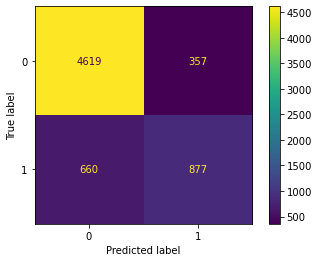

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.93      0.84      0.89      4976
           1       0.61      0.80      0.69      1537

    accuracy                           0.83      6513
   macro avg       0.77      0.82      0.79      6513
weighted avg       0.86      0.83      0.84      6513



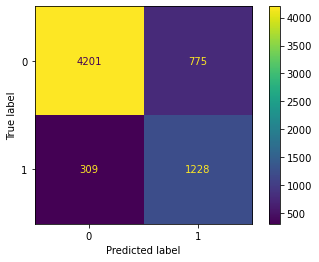

SVM Performance:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      4976
           1       0.55      0.87      0.67      1537

    accuracy                           0.80      6513
   macro avg       0.75      0.82      0.77      6513
weighted avg       0.86      0.80      0.81      6513



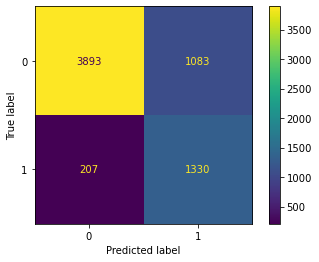

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report , confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Funzioni per il raggruppamento di alcune categorie in workclass, marital.status, relationship e hours-per-week

def group_workclass(val):
    if val in ['Federal-gov', 'Local-gov', 'State-gov']:
        return 'Government'
    elif val in ['Self-emp-inc', 'Self-emp-not-inc']:
        return 'Self-Employed'
    elif val in ['Never-worked', 'Without-pay']:
        return 'No-Income'
    else:
        return 'Private'
    
def group_marital_status(val):
    if val in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'Married'
    else:
        return 'Single'
    
def group_relationship(val):
    if val in ['Husband', 'Wife']:
        return 'Partner'
    elif val == 'Not-in-family':
        return 'Not-in-family'
    else:
        return 'Others'
    
def group_hours(hours):
    if hours < 40:
        return 'Part-time'
    elif hours == 40:
        return 'Full-time'
    elif hours <= 60:
        return 'Overtime'
    else:
        return 'Extreme'

# Caricamento del dataset conversione del file csv in un DataFrame pandas 
df = pd.read_csv('adult.csv', skipinitialspace=True )

# Filtra e mostra i record con età fuori dal range 17-90
outliers_check = df[(df['age'] > 90) | (df['age'] < 17)]

# Visualizza i risultati
if outliers_check.empty:
    print("Nessun valore trovato superiore a 90 o inferiore a 17.")
else:
    print(f"Trovati {len(outliers_check)} valori fuori range ")

# rimozione colonna education poichè ridondante con education.num e fnlwgt poichè non rilevante ai fini della predizione
df = df.drop(columns=['education'])
# df= df.drop(columns=['fnlwgt']) 

# Restituiamo tutti i valori di race
print("Valori unici della colonna race:", df['race'].unique())

# Creiamo la colonna capital net che rappresenta la differenza tra capital.gain e capital.loss e rimuoviamo le colonne originali
df['capital.net'] = df['capital.gain'] - df['capital.loss']
df = df.drop(columns=['capital.gain', 'capital.loss'])
# df['capital.net'] = np.sign(df['capital.net']) * np.log1p(np.abs(df['capital.net']))

#  Workclass raggruppato in Private, Government , Self-Employed e No-Income 
# df['workclass'] = df['workclass'].apply(group_workclass)

# Native country raggruppato in USA e Others
# df['native.country'] = df['native.country'].apply(lambda x: 'United-States' if x == 'United-States' else 'Other')

# Marital.status raggruppato in Married vs Single
# df['marital.status'] = df['marital.status'].apply(group_marital_status)

# Relationship raggruppato in Partner , Not-in-family e Others
# df['relationship'] = df['relationship'].apply(group_relationship)

# Raggruppamento della colonna hours-per-week in 4 categorie: part-time (0-39), full-time (40), over-time (41-60) e extreme (61+)
# df['hours.per.week'] = df['hours.per.week'].apply(group_hours)

# sostituzione dei valori '?' di Occupation con "UNKNOWN"
# df['occupation'] = df['occupation'].replace('?', 'UNKNOWN')

#  Sostituzione dei valori '?' con NaN
df = df.replace('?', pd.NA) 


#  Identificazione colonne con valori mancanti workclass, occupation, native-country
cols_with_nan = ['workclass', 'native.country', 'occupation']
for col in cols_with_nan:
    # Calcolo della moda (il primo elemento della serie ritornata da .mode())
    moda = df[col].mode()[0]
    # Sostituzione dei NaN con la moda
    df[col] = df[col].fillna(moda)

# Verifica
# cols_with_ver = df.columns.tolist()
# print("Colonne con valori mancanti dopo la sostituzione:", [col for col in cols_with_ver if df[col].isnull().any()])

# Rimuoviamo righe con valori mancanti 
# df = df.dropna()

# X data frame senza la colonna target 'income'
X = df.drop('income', axis=1)

# y vettore target binario
y = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Identifichiamo colonne numeriche e categoriche
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
print("Colonne numeriche:", [col for col in numeric_features])
categorical_features = X.select_dtypes(include=['object']).columns
print("Colonne categoriche:", [col for col in categorical_features])
print()

# applichiamo lo scaling alle caratteristiche numeriche e one-hot encoding a quelle categoriche
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Creiamo le Pipeline: Preprocessing + Modello
model_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,class_weight='balanced', random_state=42, solver='lbfgs', penalty='l2', C=1.0)) 
])

model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, max_depth=20, max_features='sqrt', class_weight='balanced', random_state=42))
])

model_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', class_weight='balanced', gamma='scale', random_state=42, C=1.0))
])

# Split in Training e Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento di entrambi i modelli

model_lr.fit(X_train, y_train)

model_rf.fit(X_train, y_train)

model_svm.fit(X_train, y_train)

# Valutazione sui dati di test di entrambi i modelli

y_pred_lr = model_lr.predict(X_test)

y_pred_rf = model_rf.predict(X_test)

y_pred_svm = model_svm.predict(X_test)

# Stampa del report di classificazione e matrice di confusione per entrambi i modelli

print ("Logistic Regression Performance:")

print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm).plot()
plt.show()

print("Random Forest Performance:")

print(classification_report(y_test, y_pred_rf))

cm = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm).plot()
plt.show()

print("SVM Performance:")

print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay(cm).plot()
plt.show()


In [5]:
# Analisi delle performance dei modelli in base al genere

# Funzione per calcolare selection rate e true positive rate
def get_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    selection_rate = (tp + fp) / (tn + fp + fn + tp)
    tpr = tp / (tp + fn)
    return selection_rate, tpr

# Creazione maschere per uomini e donne
mask_male = (X_test['sex'] == 'Male')
mask_female = (X_test['sex'] == 'Female')

X_testM= X_test[mask_male]
X_testF= X_test[mask_female]

y_testM = y_test[mask_male]
y_testF = y_test[mask_female]

y_pred_lr_M = model_lr.predict(X_testM)
y_pred_lr_F = model_lr.predict(X_testF)
y_pred_rf_M = model_rf.predict(X_testM)
y_pred_rf_F = model_rf.predict(X_testF)

# Calcolo delle metriche di selezione e true positive rate per uomini e donne
sr_donne_lr, tpr_donne_lr = get_metrics(y_testF, y_pred_lr_F)
sr_uomini_lr, tpr_uomini_lr = get_metrics(y_testM, y_pred_lr_M)
sr_donne_rf, tpr_donne_rf = get_metrics(y_testF, y_pred_rf_F)
sr_uomini_rf, tpr_uomini_rf = get_metrics(y_testM, y_pred_rf_M)

# Calcolo del Disparate Impact e dell'Equal Opportunity Difference
disparate_impact_sex_lr = sr_donne_lr / sr_uomini_lr if sr_uomini_lr > 0 else 0
equal_opportunity_diff_sex_lr = tpr_donne_lr - tpr_uomini_lr
disparate_impact_sex_rf = sr_donne_rf / sr_uomini_rf if sr_uomini_rf > 0 else 0
equal_opportunity_diff_sex_rf = tpr_donne_rf - tpr_uomini_rf

print("Logistic Regression - Analisi di genere:")
print(f"Disparate Impact: {disparate_impact_sex_lr:.3f}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_sex_lr:.3f}")
print()
print("Random Forest - Analisi di genere:")
print(f"Disparate Impact: {disparate_impact_sex_rf:.3f}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_sex_rf:.3f}")



Logistic Regression - Analisi di genere:
Disparate Impact: 0.278
Equal Opportunity Difference: -0.134

Random Forest - Analisi di genere:
Disparate Impact: 0.241
Equal Opportunity Difference: -0.176


In [6]:
mask_white = (X_test['race'] == 'White')
mask_other = (X_test['race'] != 'White')

X_testW= X_test[mask_white]
X_testO= X_test[mask_other]

y_testW = y_test[mask_white]
y_testO = y_test[mask_other]

y_pred_lr_W = model_lr.predict(X_testW)
y_pred_lr_O = model_lr.predict(X_testO)
y_pred_rf_W = model_rf.predict(X_testW)
y_pred_rf_O = model_rf.predict(X_testO)

# Calcolo delle metriche di selezione e true positive rate per white e altre razze
sr_other, tpr_other_lr = get_metrics(y_testO, y_pred_lr_O)
sr_white, tpr_white_lr = get_metrics(y_testW, y_pred_lr_W)
sr_other_rf, tpr_other_rf = get_metrics(y_testO, y_pred_rf_O)
sr_white_rf, tpr_white_rf = get_metrics(y_testW, y_pred_rf_W)

# Calcolo del Disparate Impact e dell'Equal Opportunity Difference
disparate_impact_race_lr = sr_other / sr_white if sr_white > 0 else 0
equal_opportunity_diff_race_lr = tpr_other_lr - tpr_white_lr
disparate_impact_race_rf = sr_other_rf / sr_white_rf if sr_white_rf > 0 else 0
equal_opportunity_diff_race_rf = tpr_other_rf - tpr_white_rf

print("Logistic Regression - Analisi di razza:")
print(f"Disparate Impact: {disparate_impact_race_lr:.3f}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_race_lr:.3f}")
print()
print("Random Forest - Analisi di razza:")
print(f"Disparate Impact: {disparate_impact_race_rf:.3f}")
print(f"Equal Opportunity Difference: {equal_opportunity_diff_race_rf:.3f}")

Logistic Regression - Analisi di razza:
Disparate Impact: 0.514
Equal Opportunity Difference: -0.116

Random Forest - Analisi di razza:
Disparate Impact: 0.474
Equal Opportunity Difference: -0.134
